In [1]:
from PyHa.statistics import *
from PyHa.IsoAutio import *
from PyHa.visualizations import *
from PyHa.annotation_post_processing import *
import pandas as pd

`ground_truth`: manually created annotations  
`t2fn` : TweetyNet to Filename  
`t2bnl_chunk` : chunked TweetyNet labels fed into BirdNET Lite  
`t2bnl_exact` : TweetyNet labels, then overlay BirdNET Lite species  
`bnl`: BirdNET-Lite native output  

In [2]:
ground_truth_df = pd.read_csv("COSMOS_Manual_Labels_Anonymized_SRS.csv")
t2fn_df = pd.read_csv("COSMOS_TweetyNet_Labels_SRS.csv")
t2bnl_chunk_df = pd.read_csv("COSMOS_TweetyNet-to-BirdNET_Labels_SRS.csv")
t2bnl_exact_df = pd.read_csv("COSMOS_TweetyNet-BirdNET-Overlay_Labels_SRS.csv")
bnl_df = pd.read_csv("COSMOS_BirdNET-Lite_Labels_SRS.csv")

In [3]:
df_list = [ground_truth_df,
          t2fn_df,
          t2bnl_chunk_df,
          t2bnl_exact_df,
          bnl_df]
df_names = ["Ground Truth",
           "TweetyNet to Filename",
           "TweetyNet to BirdNET-Lite, Chunked",
           "TweetyNet to BirdNET-Lite, Exact",
           "BirdNET-Lite"]
path = "./cosmos_random_sample_processing/"

### Setup and String Parsing

In [4]:
# replace scientific name with common name
def swap_scientific_common(scientific):
    try:
        return mddd[mddd["Species"] == scientific]["Common"].iloc[0]
    except:
        return scientific
    
# replace common name with scientific name
def swap_common_scientific(common):
    try:
        return mddd[mddd["Common"] == common]["Species"].iloc[0]
    except:
        return common

# fix up the data :D
def string_parsing(df):
    # conforming to naming conventions
    df['MANUAL ID'] = df['MANUAL ID'].replace('Bird', 'bird')
    df['MANUAL ID'] = df['MANUAL ID'].replace(' Rufous-collared Sparrow', 'Rufous-collared Sparrow')
    df['MANUAL ID'] = df['MANUAL ID'].replace(' Southern Nightingale-Wren', 'Southern Nightingale-Wren')
    df['FOLDER'] = path
    # turn manual ids from scientific to common
    df["SCIENTIFIC"] = df["MANUAL ID"]
    df["COMMON"] = df["MANUAL ID"].apply(swap_scientific_common)
    return df

# parse common species name from the file name
def file_to_class_name(df):
    df["CLASS NAME"] = df["IN FILE"].apply(lambda x: x.replace("_", " "))
    df["CLASS NAME"] = df["CLASS NAME"].apply(lambda x: x.split(" - ")[1])
    return df

# use filename to change manual id to scientific, species-specific name
def file_to_scientific_name(df):
    df["MANUAL ID"] = df["IN FILE"].apply(lambda x: " ".join(x.replace("_", " ").split(" - ")[-1].replace(".mp3", "").split()[:2]))
    return df

### General Dataset Statistics

In [5]:
# general dataset statistics
def dataset_statistics(df):
    print("Total number of clips:", df["IN FILE"].nunique())
    print("Total number of annotations made:", df.shape[0])
    print("Total duration of clips:", round(df.groupby(by=["IN FILE"]).mean()["CLIP LENGTH"].sum() / 60 / 60, 4), "hours")
    print("Total duration of annotations made:", round(df['DURATION'].sum() / 60 / 60, 4), "hours")

# Total length of annotations per class labeled
def class_annotation_duration(df) :
    display(pd.DataFrame(df.groupby(by=["IN FILE", "MANUAL ID"]).mean().reset_index().groupby(by=["MANUAL ID"]).sum()["CLIP LENGTH"]).sort_values(by="CLIP LENGTH", ascending=False).head(20))

### Class Statistics

In [6]:
def gen_class_labels(df):
    class_labels = df["CLASS NAME"].unique().tolist()
    class_labels.sort()
    return class_labels

    
# replace any species specific annotations that aren't the class name with "bird"
def replace_all_with_bird(df):
    class_labels = gen_class_labels(df)
    df.loc[~df["COMMON"].isin(class_labels), "COMMON"] = "bird"
    return df

# replace any labels that aren't in the class list
def replace_non_class_labels(df):
    class_labels = gen_class_labels(df)
    df.loc[~df["COMMON"].isin(class_labels), "COMMON"] = "bird"
    display(df.groupby(by=["IN FILE", "COMMON"]).sum())
    return df

In [7]:
def gen_stacked_bar_chart(df, title=""):
    # filter by duration of each species in each clip class
    class_duration = df.groupby(by=["CLASS NAME", "COMMON"])["DURATION"].sum().reset_index()
    # total duration of ALL annotations for each class
    all_classes = class_duration.groupby(by="CLASS NAME")["DURATION"].sum().to_list()
    # total duration of species-level annotations for each class
    classes_only = class_duration[class_duration["CLASS NAME"] == class_duration["COMMON"]]["DURATION"].to_list()
    # total duration of audio
    class_df_nodupes = df.drop_duplicates(subset=["CLIP LENGTH"], keep='first')
    clip_duration_by_class = class_df_nodupes.groupby("CLASS NAME")["CLIP LENGTH"].sum().to_list()
    # generate list of class labels
    class_labels = gen_class_labels(df)
    
    # generate barchart
    y = np.arange(len(classes_only))

    fig, ax = plt.subplots()
    cd_b_c = ax.barh(y,clip_duration_by_class, label="Unlabeled Audio")
    b_length = ax.barh(y, all_classes, label="Generic Bird Labels")
    cl_length = ax.barh(y, classes_only, label="Species-Specific Labels")


    for bar in ax.patches:
        value = bar.get_height()
        text = f'{value}'

    ax.set_title(title)
    ax.set_xlabel('Duration (s)')
    ax.set_yticks(y)
    ax.set_yticklabels(class_labels)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    return df

# let's analyze some data :D

In [8]:
# apply file names to tweety df, since it just outputs "bird"
t2fn_df = file_to_scientific_name(t2fn_df)

In [9]:
mddd = pd.read_csv("MadreDeDiosXCBirdList.csv")

In [10]:
ground_truth_df

,Unnamed: 0,IN FILE,CLIP LENGTH,OFFSET,DURATION,MAX FREQ,MIN FREQ,SAMPLE RATE,MANUAL ID,TIME_SPENT,LAST MOD BY,CONFIDENCE,RETIRED,COUNTED,FOLDER,COMMON,SCIENTIFIC
0,0,XC87449_-_Scaly-breasted_Woodpecker_-_Celeus_g...,23.2956,0.7025,0.9199,24000,0,44100,Celeus grammicus,365.822,Jared Smith,0,False,0,./COSMOS,Scaly-breasted Woodpecker,Celeus grammicus
1,1,XC87449_-_Scaly-breasted_Woodpecker_-_Celeus_g...,23.2956,4.6223,0.9400,24000,0,44100,Celeus grammicus,365.822,Jared Smith,0,False,0,./COSMOS,Scaly-breasted Woodpecker,Celeus grammicus
2,2,XC87449_-_Scaly-breasted_Woodpecker_-_Celeus_g...,23.2956,11.4420,0.9300,24000,0,44100,Celeus grammicus,176.450,Jared Smith,0,False,0,./COSMOS,Scaly-breasted Woodpecker,Celeus grammicus
3,3,XC87449_-_Scaly-breasted_Woodpecker_-_Celeus_g...,23.2956,18.4117,0.8700,24000,0,44100,Celeus grammicus,365.822,Jared Smith,0,False,0,./COSMOS,Scaly-breasted Woodpecker,Celeus grammicus
4,4,XC87449_-_Scaly-breasted_Woodpecker_-_Celeus_g...,23.2956,21.9915,0.7600,24000,0,44100,Celeus grammicus,176.450,Jared Smith,0,False,0,./COSMOS,Scaly-breasted Woodpecker,Celeus grammicus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5187,5187,XC27942_-_Yellow-olive_Flatbill_-_Tolmomyias_s...,31.3404,15.4774,0.4799,24000,0,44100,Tolmomyias sulphurescens,76.420,Jason Benson,0,False,0,./COSMOS,Yellow-olive Flatbill,Tolmomyias sulphurescens
5188,5188,XC27942_-_Yellow-olive_Flatbill_-_Tolmomyias_s...,31.3404,5.4311,0.5899,24000,0,44100,Tolmomyias sulphurescens,76.420,Jason Benson,0,False,0,./COSMOS,Yellow-olive Flatbill,Tolmomyias sulphurescens
5189,5189,XC27942_-_Yellow-olive_Flatbill_-_Tolmomyias_s...,31.3404,7.1648,0.6299,24000,0,44100,Tolmomyias sulphurescens,76.420,Jason Benson,0,False,0,./COSMOS,Yellow-olive Flatbill,Tolmomyias sulphurescens
5190,5190,XC27942_-_Yellow-olive_Flatbill_-_Tolmomyias_s...,31.3404,10.3063,0.4499,24000,0,44100,Tolmomyias sulphurescens,76.420,Jason Benson,0,False,0,./COSMOS,Yellow-olive Flatbill,Tolmomyias sulphurescens


In [11]:
i = 0
for df in df_list:
    print("\n\n" + df_names[i])
    df = string_parsing(df)
    df = file_to_class_name(df)
    dataset_statistics(df)
    display(df)
    i+=1



Ground Truth
Total number of clips: 498
Total number of annotations made: 5192
Total duration of clips: 5.7217 hours
Total duration of annotations made: 2.6558 hours


,Unnamed: 0,IN FILE,CLIP LENGTH,OFFSET,DURATION,MAX FREQ,MIN FREQ,SAMPLE RATE,MANUAL ID,TIME_SPENT,LAST MOD BY,CONFIDENCE,RETIRED,COUNTED,FOLDER,COMMON,SCIENTIFIC,CLASS NAME
0,0,XC87449_-_Scaly-breasted_Woodpecker_-_Celeus_g...,23.2956,0.7025,0.9199,24000,0,44100,Celeus grammicus,365.822,Jared Smith,0,False,0,./cosmos_random_sample_processing/,Scaly-breasted Woodpecker,Celeus grammicus,Scaly-breasted Woodpecker
1,1,XC87449_-_Scaly-breasted_Woodpecker_-_Celeus_g...,23.2956,4.6223,0.9400,24000,0,44100,Celeus grammicus,365.822,Jared Smith,0,False,0,./cosmos_random_sample_processing/,Scaly-breasted Woodpecker,Celeus grammicus,Scaly-breasted Woodpecker
2,2,XC87449_-_Scaly-breasted_Woodpecker_-_Celeus_g...,23.2956,11.4420,0.9300,24000,0,44100,Celeus grammicus,176.450,Jared Smith,0,False,0,./cosmos_random_sample_processing/,Scaly-breasted Woodpecker,Celeus grammicus,Scaly-breasted Woodpecker
3,3,XC87449_-_Scaly-breasted_Woodpecker_-_Celeus_g...,23.2956,18.4117,0.8700,24000,0,44100,Celeus grammicus,365.822,Jared Smith,0,False,0,./cosmos_random_sample_processing/,Scaly-breasted Woodpecker,Celeus grammicus,Scaly-breasted Woodpecker
4,4,XC87449_-_Scaly-breasted_Woodpecker_-_Celeus_g...,23.2956,21.9915,0.7600,24000,0,44100,Celeus grammicus,176.450,Jared Smith,0,False,0,./cosmos_random_sample_processing/,Scaly-breasted Woodpecker,Celeus grammicus,Scaly-breasted Woodpecker
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5187,5187,XC27942_-_Yellow-olive_Flatbill_-_Tolmomyias_s...,31.3404,15.4774,0.4799,24000,0,44100,Tolmomyias sulphurescens,76.420,Jason Benson,0,False,0,./cosmos_random_sample_processing/,Yellow-olive Flatbill,Tolmomyias sulphurescens,Yellow-olive Flatbill
5188,5188,XC27942_-_Yellow-olive_Flatbill_-_Tolmomyias_s...,31.3404,5.4311,0.5899,24000,0,44100,Tolmomyias sulphurescens,76.420,Jason Benson,0,False,0,./cosmos_random_sample_processing/,Yellow-olive Flatbill,Tolmomyias sulphurescens,Yellow-olive Flatbill
5189,5189,XC27942_-_Yellow-olive_Flatbill_-_Tolmomyias_s...,31.3404,7.1648,0.6299,24000,0,44100,Tolmomyias sulphurescens,76.420,Jason Benson,0,False,0,./cosmos_random_sample_processing/,Yellow-olive Flatbill,Tolmomyias sulphurescens,Yellow-olive Flatbill
5190,5190,XC27942_-_Yellow-olive_Flatbill_-_Tolmomyias_s...,31.3404,10.3063,0.4499,24000,0,44100,Tolmomyias sulphurescens,76.420,Jason Benson,0,False,0,./cosmos_random_sample_processing/,Yellow-olive Flatbill,Tolmomyias sulphurescens,Yellow-olive Flatbill




TweetyNet to Filename
Total number of clips: 482
Total number of annotations made: 9319
Total duration of clips: 5.6235 hours
Total duration of annotations made: 3.0937 hours


,Unnamed: 0,OFFSET,DURATION,FOLDER,IN FILE,CHANNEL,CLIP LENGTH,SAMPLE RATE,MANUAL ID,CONFIDENCE,SCIENTIFIC,COMMON,CLASS NAME
0,0,0.558140,1.767442,./cosmos_random_sample_processing/,XC100864 - Rufous-collared Sparrow - Zonotrich...,0,9.299592,44100,Zonotrichia capensis,0.914495,Zonotrichia capensis,Rufous-collared Sparrow,Rufous-collared Sparrow
1,1,4.325581,0.093023,./cosmos_random_sample_processing/,XC100864 - Rufous-collared Sparrow - Zonotrich...,0,9.299592,44100,Zonotrichia capensis,0.157588,Zonotrichia capensis,Rufous-collared Sparrow,Rufous-collared Sparrow
2,2,6.046512,8.000000,./cosmos_random_sample_processing/,XC100864 - Rufous-collared Sparrow - Zonotrich...,0,9.299592,44100,Zonotrichia capensis,1.000000,Zonotrichia capensis,Rufous-collared Sparrow,Rufous-collared Sparrow
3,3,1.441860,0.558140,./cosmos_random_sample_processing/,XC101469 - Pale-breasted Thrush - Turdus leuco...,0,137.377959,44100,Turdus leucomelas,0.743005,Turdus leucomelas,Pale-breasted Thrush,Pale-breasted Thrush
4,4,2.000000,0.232558,./cosmos_random_sample_processing/,XC101469 - Pale-breasted Thrush - Turdus leuco...,0,137.377959,44100,Turdus leucomelas,0.706071,Turdus leucomelas,Pale-breasted Thrush,Pale-breasted Thrush
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9314,9314,6.488372,0.441860,./cosmos_random_sample_processing/,XC9766 - Rufous-collared Sparrow - Zonotrichia...,0,11.232653,44100,Zonotrichia capensis,0.355972,Zonotrichia capensis,Rufous-collared Sparrow,Rufous-collared Sparrow
9315,9315,6.953488,0.162791,./cosmos_random_sample_processing/,XC9766 - Rufous-collared Sparrow - Zonotrichia...,0,11.232653,44100,Zonotrichia capensis,0.233995,Zonotrichia capensis,Rufous-collared Sparrow,Rufous-collared Sparrow
9316,9316,7.116279,0.046512,./cosmos_random_sample_processing/,XC9766 - Rufous-collared Sparrow - Zonotrichia...,0,11.232653,44100,Zonotrichia capensis,0.271501,Zonotrichia capensis,Rufous-collared Sparrow,Rufous-collared Sparrow
9317,9317,7.790698,0.930233,./cosmos_random_sample_processing/,XC9766 - Rufous-collared Sparrow - Zonotrichia...,0,11.232653,44100,Zonotrichia capensis,0.668926,Zonotrichia capensis,Rufous-collared Sparrow,Rufous-collared Sparrow




TweetyNet to BirdNET-Lite, Chunked
Total number of clips: 476
Total number of annotations made: 5086
Total duration of clips: 5.6179 hours
Total duration of annotations made: 4.2383 hours


,Unnamed: 0,FOLDER,IN FILE,CLIP LENGTH,CHANNEL,OFFSET,DURATION,SAMPLE RATE,MANUAL ID,CONFIDENCE,SCIENTIFIC,COMMON,CLASS NAME
0,0,./cosmos_random_sample_processing/,XC100864 - Rufous-collared Sparrow - Zonotrich...,9.299604,0,0.0,3.0,48000,Zonotrichia capensis,0.981316,Zonotrichia capensis,Rufous-collared Sparrow,Rufous-collared Sparrow
1,1,./cosmos_random_sample_processing/,XC100864 - Rufous-collared Sparrow - Zonotrich...,9.299604,0,3.0,3.0,48000,Zonotrichia capensis,0.455129,Zonotrichia capensis,Rufous-collared Sparrow,Rufous-collared Sparrow
2,2,./cosmos_random_sample_processing/,XC100864 - Rufous-collared Sparrow - Zonotrich...,9.299604,0,6.0,3.0,48000,Zonotrichia capensis,0.958481,Zonotrichia capensis,Rufous-collared Sparrow,Rufous-collared Sparrow
3,3,./cosmos_random_sample_processing/,XC101469 - Pale-breasted Thrush - Turdus leuco...,137.377979,0,0.0,3.0,48000,Mimus gilvus,0.130503,Mimus gilvus,Mimus gilvus,Pale-breasted Thrush
4,4,./cosmos_random_sample_processing/,XC101469 - Pale-breasted Thrush - Turdus leuco...,137.377979,0,3.0,3.0,48000,Mimus gilvus,0.066429,Mimus gilvus,Mimus gilvus,Pale-breasted Thrush
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5081,5081,./cosmos_random_sample_processing/,XC97532 - Blue-grey Tanager - Thraupis episcop...,20.297146,0,15.0,3.0,48000,Bubo ascalaphus,0.013156,Bubo ascalaphus,Bubo ascalaphus,Blue-grey Tanager
5082,5082,./cosmos_random_sample_processing/,XC97542 - Slate-throated Whitestart - Myioboru...,4.362458,0,0.0,3.0,48000,Thlypopsis sordida,0.023451,Thlypopsis sordida,Orange-headed Tanager,Slate-throated Whitestart
5083,5083,./cosmos_random_sample_processing/,XC9766 - Rufous-collared Sparrow - Zonotrichia...,11.232667,0,0.0,3.0,48000,Empidonax traillii,0.121914,Empidonax traillii,Empidonax traillii,Rufous-collared Sparrow
5084,5084,./cosmos_random_sample_processing/,XC9766 - Rufous-collared Sparrow - Zonotrichia...,11.232667,0,3.0,3.0,48000,Merops pusillus,0.040642,Merops pusillus,Merops pusillus,Rufous-collared Sparrow




TweetyNet to BirdNET-Lite, Exact
Total number of clips: 482
Total number of annotations made: 12946
Total duration of clips: 5.6235 hours
Total duration of annotations made: 3.0937 hours


,Unnamed: 0.1,Unnamed: 0,OFFSET,DURATION,FOLDER,IN FILE,CHANNEL,CLIP LENGTH,SAMPLE RATE,MANUAL ID,CONFIDENCE,END_TIME,SPLIT,FILEKEY,START_TIME,SCIENTIFIC,COMMON,CLASS NAME
0,0,0,0.558140,1.767442,./cosmos_random_sample_processing/,XC100864 - Rufous-collared Sparrow - Zonotrich...,0,9.299592,44100,Zonotrichia capensis,0.914495,2.325581,NaN,XC100864,0.558140,Zonotrichia capensis,Rufous-collared Sparrow,Rufous-collared Sparrow
1,1,1,4.325581,0.093023,./cosmos_random_sample_processing/,XC100864 - Rufous-collared Sparrow - Zonotrich...,0,9.299592,44100,Zonotrichia capensis,0.157588,4.418605,NaN,XC100864,4.325581,Zonotrichia capensis,Rufous-collared Sparrow,Rufous-collared Sparrow
2,2,2,6.046512,2.953488,./cosmos_random_sample_processing/,XC100864 - Rufous-collared Sparrow - Zonotrich...,0,9.299592,44100,Zonotrichia capensis,1.000000,9.000000,"[6.046511627906977, 9]",XC100864,6.046512,Zonotrichia capensis,Rufous-collared Sparrow,Rufous-collared Sparrow
3,3,2,9.000000,3.000000,./cosmos_random_sample_processing/,XC100864 - Rufous-collared Sparrow - Zonotrich...,0,9.299592,44100,bird,1.000000,12.000000,"[9, 12]",XC100864,9.000000,bird,bird,Rufous-collared Sparrow
4,4,2,12.000000,2.046512,./cosmos_random_sample_processing/,XC100864 - Rufous-collared Sparrow - Zonotrich...,0,9.299592,44100,bird,1.000000,14.046512,"[12, 14.046511627906977]",XC100864,12.000000,bird,bird,Rufous-collared Sparrow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12941,12941,9314,6.488372,0.441860,./cosmos_random_sample_processing/,XC9766 - Rufous-collared Sparrow - Zonotrichia...,0,11.232653,44100,Pardirallus sanguinolentus,0.355972,6.930233,NaN,XC9766,6.488372,Pardirallus sanguinolentus,Pardirallus sanguinolentus,Rufous-collared Sparrow
12942,12942,9315,6.953488,0.162791,./cosmos_random_sample_processing/,XC9766 - Rufous-collared Sparrow - Zonotrichia...,0,11.232653,44100,Pardirallus sanguinolentus,0.233995,7.116279,NaN,XC9766,6.953488,Pardirallus sanguinolentus,Pardirallus sanguinolentus,Rufous-collared Sparrow
12943,12943,9316,7.116279,0.046512,./cosmos_random_sample_processing/,XC9766 - Rufous-collared Sparrow - Zonotrichia...,0,11.232653,44100,Pardirallus sanguinolentus,0.271501,7.162791,NaN,XC9766,7.116279,Pardirallus sanguinolentus,Pardirallus sanguinolentus,Rufous-collared Sparrow
12944,12944,9317,7.790698,0.930233,./cosmos_random_sample_processing/,XC9766 - Rufous-collared Sparrow - Zonotrichia...,0,11.232653,44100,Pardirallus sanguinolentus,0.668926,8.720930,NaN,XC9766,7.790698,Pardirallus sanguinolentus,Pardirallus sanguinolentus,Rufous-collared Sparrow




BirdNET-Lite
Total number of clips: 495
Total number of annotations made: 6812
Total duration of clips: 5.6798 hours
Total duration of annotations made: 5.6767 hours


,Unnamed: 0,FOLDER,IN FILE,CLIP LENGTH,CHANNEL,OFFSET,DURATION,SAMPLE RATE,MANUAL ID,CONFIDENCE,SCIENTIFIC,COMMON,CLASS NAME
0,0,./cosmos_random_sample_processing/,XC100864 - Rufous-collared Sparrow - Zonotrich...,9.299604,0,0.0,3.0,48000,Zonotrichia capensis,0.981316,Zonotrichia capensis,Rufous-collared Sparrow,Rufous-collared Sparrow
1,1,./cosmos_random_sample_processing/,XC100864 - Rufous-collared Sparrow - Zonotrich...,9.299604,0,3.0,3.0,48000,Zonotrichia capensis,0.455129,Zonotrichia capensis,Rufous-collared Sparrow,Rufous-collared Sparrow
2,2,./cosmos_random_sample_processing/,XC100864 - Rufous-collared Sparrow - Zonotrich...,9.299604,0,6.0,3.0,48000,Zonotrichia capensis,0.958481,Zonotrichia capensis,Rufous-collared Sparrow,Rufous-collared Sparrow
3,3,./cosmos_random_sample_processing/,XC101469 - Pale-breasted Thrush - Turdus leuco...,137.377979,0,0.0,3.0,48000,Mimus gilvus,0.130503,Mimus gilvus,Mimus gilvus,Pale-breasted Thrush
4,4,./cosmos_random_sample_processing/,XC101469 - Pale-breasted Thrush - Turdus leuco...,137.377979,0,3.0,3.0,48000,Mimus gilvus,0.066429,Mimus gilvus,Mimus gilvus,Pale-breasted Thrush
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6807,6807,./cosmos_random_sample_processing/,XC97542 - Slate-throated Whitestart - Myioboru...,4.362458,0,0.0,3.0,48000,Thlypopsis sordida,0.023451,Thlypopsis sordida,Orange-headed Tanager,Slate-throated Whitestart
6808,6808,./cosmos_random_sample_processing/,XC9766 - Rufous-collared Sparrow - Zonotrichia...,11.232667,0,0.0,3.0,48000,Empidonax traillii,0.121914,Empidonax traillii,Empidonax traillii,Rufous-collared Sparrow
6809,6809,./cosmos_random_sample_processing/,XC9766 - Rufous-collared Sparrow - Zonotrichia...,11.232667,0,3.0,3.0,48000,Merops pusillus,0.040642,Merops pusillus,Merops pusillus,Rufous-collared Sparrow
6810,6810,./cosmos_random_sample_processing/,XC9766 - Rufous-collared Sparrow - Zonotrichia...,11.232667,0,6.0,3.0,48000,Pardirallus sanguinolentus,0.059656,Pardirallus sanguinolentus,Pardirallus sanguinolentus,Rufous-collared Sparrow


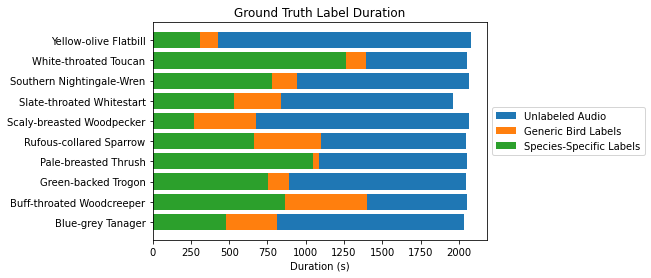

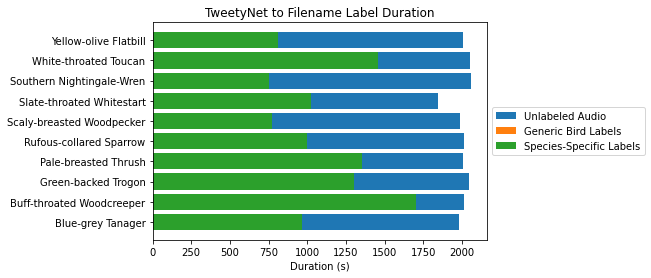

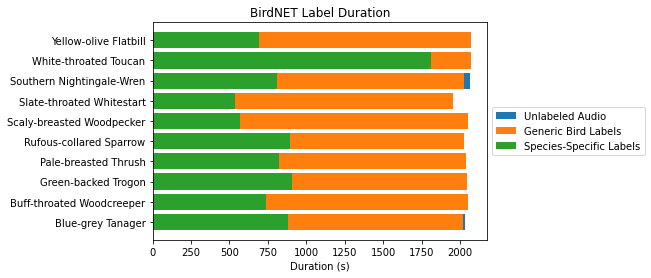

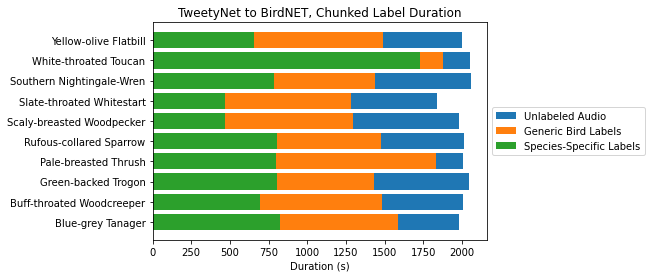

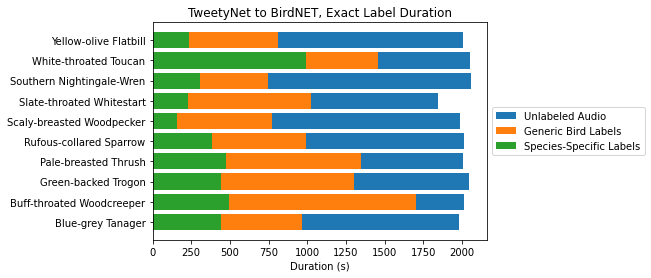

In [12]:
gen_stacked_bar_chart(ground_truth_df, "Ground Truth Label Duration");
gen_stacked_bar_chart(t2fn_df, "TweetyNet to Filename Label Duration");
gen_stacked_bar_chart(bnl_df, "BirdNET Label Duration");
gen_stacked_bar_chart(t2bnl_chunk_df, "TweetyNet to BirdNET, Chunked Label Duration");
gen_stacked_bar_chart(t2bnl_exact_df, "TweetyNet to BirdNET, Exact Label Duration");

In [39]:
# class_df_species = manual_df.copy()
# class_df_species["IN FILE"] = class_df_species["IN FILE"].apply(lambda x: x.replace("_", " "))
# class_df_species["IN FILE"] = class_df_species["IN FILE"].apply(lambda x: x.split(" - ")[1])
# cols = [0,1,2]
# class_df_species.drop(class_df_species.columns[cols],axis = 1, inplace=True)
# class_labels = class_df_species["IN FILE"].unique().tolist()
# class_labels.sort()
# class_df_species.loc[~class_df_species["COMMON"].isin(class_labels), "COMMON"] = "bird"
# #class_df_species
# class_df_species.groupby(by=["IN FILE", "COMMON"]).sum()

DURATION  CHANNEL  \
IN FILE                   COMMON                                            
Blue-grey Tanager         Blue-grey Tanager           444.976744        0   
                          Buff-throated Woodcreeper     1.441860        0   
                          bird                        519.046512        0   
Buff-throated Woodcreeper Buff-throated Woodcreeper   495.837209        0   
                          Green-backed Trogon           9.581395        0   
                          White-throated Toucan         5.093023        0   
                          bird                       1190.581395        0   
Green-backed Trogon       Green-backed Trogon         443.883721        0   
                          Scaly-breasted Woodpecker     0.116279        0   
                          bird                        855.813953        0   
Pale-breasted Thrush      Blue-grey Tanager             1.093023        0   
                          Pale-breasted Thrush        475.813953        0   
                          bird                        878.790698        0   
Rufous-collared Sparrow   Rufous-collared Sparrow     387.093023        0   
                          bird                        610.093023        0   
Scaly-breasted Woodpecker Buff-throated Woodcreeper     2.790698        0   
                          Green-backed Trogon          11.000000        0   
                          Scaly-breasted Woodpecker   159.731623        0   
                          bird                        598.488372        0   
Slate-throated Whitestart Blue-grey Tanager             0.488372        0   
                          Slate-throated Whitestart   230.790698        0   
                          bird                        793.372093        0   
Southern Nightingale-Wren Southern Nightingale-Wren   308.906977        0   
                          White-throated Toucan         0.023256        0   
                          bird                        443.162791        0   
White-throated Toucan     White-throated Toucan       992.651163        0   
                          bird                        466.395349        0   
Yellow-olive Flatbill     Buff-throated Woodcreeper     0.162791        0   
                          Yellow-olive Flatbill       234.488372        0   
                          bird                        575.534884        0   

                                                       CLIP LENGTH  \
IN FILE                   COMMON                                     
Blue-grey Tanager         Blue-grey Tanager           51447.441769   
                          Buff-throated Woodcreeper     153.474082   
                          bird                        47096.504762   
Buff-throated Woodcreeper Buff-throated Woodcreeper   27036.694331   
                          Green-backed Trogon          5032.367800   
                          White-throated Toucan         421.773061   
                          bird                       100501.642857   
Green-backed Trogon       Green-backed Trogon         66699.759025   
                          Scaly-breasted Woodpecker      96.156735   
                          bird                        63783.823946   
Pale-breasted Thrush      Blue-grey Tanager            1025.339002   
                          Pale-breasted Thrush        54901.640023   
                          bird                        79707.284921   
Rufous-collared Sparrow   Rufous-collared Sparrow     27129.069070   
                          bird                        43995.750431   
Scaly-breasted Woodpecker Buff-throated Woodcreeper     186.413333   
                          Green-backed Trogon          1023.666667   
                          Scaly-breasted Woodpecker   25436.916599   
                          bird                        71024.665828   
Slate-throated Whitestart Blue-grey Tanager              51.860476   
                          Slate-throated Whitestart

# Annotation Duration Histograms and Statistics

In [ ]:
annotation_duration_statistics(manual_df)

In [ ]:
# All annotations
annotation_duration_histogram(manual_df, n_bins = 100, title = "T2B Annotation Lengths")

In [ ]:
# Species-specific labels
classes_only_df = class_df[class_df["IN FILE"] == class_df["COMMON"]]
classes_only_df_99 = classes_only_df[classes_only_df["DURATION"] < classes_only_df["DURATION"].quantile(0.99)]
annotation_duration_histogram(classes_only_df_99, n_bins=100, title="Species-Specific Annotation Lengths")
annotation_duration_statistics(classes_only_df)

In [ ]:
# Generic bird labels
bird_only_df = class_df[class_df["MANUAL ID"] == "bird"]
bird_only_df_99 = bird_only_df[bird_only_df["DURATION"] < bird_only_df["DURATION"].quantile(0.99)]
annotation_duration_histogram(bird_only_df_99, n_bins=100, title="Generic Bird Annotation Lengths")
annotation_duration_statistics(bird_only_df)

In [ ]:
# Annotation duration lengths per specific classes
list_of_classes = class_df["MANUAL ID"].unique().tolist()
list_of_classes.sort()

for species in list_of_classes:
    species_df = class_df[class_df["MANUAL ID"] == species]
    annotation_duration_histogram(species_df, n_bins=100, title=swap_scientific_common(species) + " Annotation Lengths")